In [ ]:
# Unzipping the dataset to extract a csv file
!gunzip 2022.csv.gz

In [ ]:
#Import all the required libraries

import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import altair as alt
import seaborn as sns
from sklearn.cluster import KMeans

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

## Data Exploration and Preprocessing (Demonstration)

In [ ]:
#Assigning columns to the dataframe
cols=["ID","date","ELEMENT","READING","M","Q","S","time"]

#Taking first 10 million entries just to see what the dataset looks like
df2=pd.read_csv("2022.csv",header=None,names=cols,nrows = 10000000)

#Changing date to date format (Initial was an integer format)
df2['date'] = pd.to_datetime(df2['date'], format='%Y%m%d', errors='coerce')

In [ ]:
#Since the Q column stands for a quality check, we have to discard all the
#columns where Q is not blank (As values in which Q has entries have failed quality checks)

not_na_count_q = df2['Q'].count()
print(f"Number of non-NaN entries in the 'Q' column: {not_na_count_q}")

Number of non-NaN entries in the 'Q' column: 16129


In [ ]:
#Drop the values where the Q flag is not blank
df2 = df2[pd.isna(df2['Q'])]

In [ ]:
#Seeing what the dataset looks like
df2.describe()

,READING,time
count,9.983871e+06,4.812370e+06
mean,1.577332e+02,8.952336e+02
std,9.907689e+02,4.657799e+02
min,-7.080000e+02,0.000000e+00
25%,0.000000e+00,7.000000e+02
50%,0.000000e+00,7.000000e+02
75%,7.000000e+01,8.000000e+02
max,2.621300e+04,2.400000e+03


In [ ]:
#Setting display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Show only those elements char values which have been printed a lot (As they are useful elements)
print(df2['ELEMENT'].value_counts(dropna=False)[0:10])

PRCP    2826423
SNOW    1442820
TMIN    1156325
TMAX    1152369
SNWD     969680
TAVG     603854
TOBS     429950
WESD     148253
WESF     128793
AWND     109991
Name: ELEMENT, dtype: int64


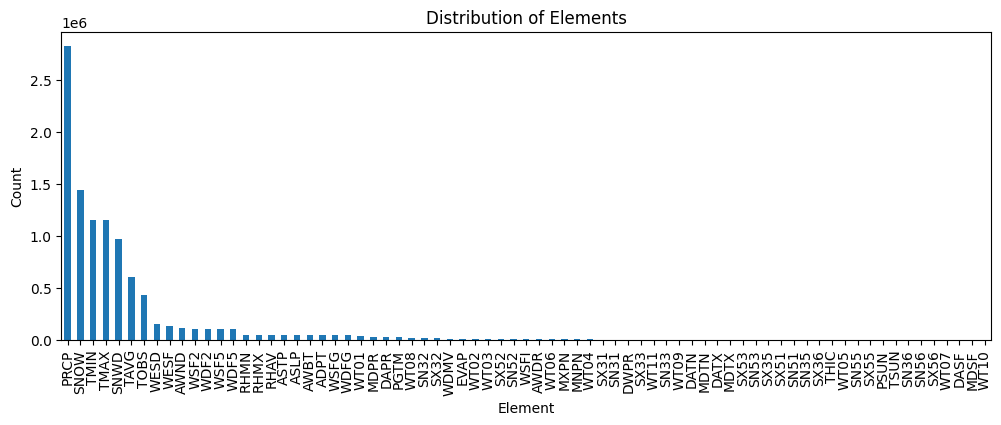

In [ ]:
#Visualize the above in a graphical format (bar plot) to see the count of
#value(s) present in the dataframe

plt.figure(figsize=(12, 4))
df2['ELEMENT'].value_counts().plot(kind='bar')
plt.title('Distribution of Elements')
plt.xlabel('Element')
plt.ylabel('Count')
plt.show()

In [ ]:
#Pivoting the dataframe to make the most important element values as seperate columns
df2=df2.pivot_table(index=['ID', 'date'], columns='ELEMENT', values='READING').reset_index()

In [ ]:
#Checking for missing values in each column and sort in descending order
missing_values_per_column = df2.isna().sum().sort_values(ascending=True)

print("Number of missing values per column (descending order):")
print(missing_values_per_column)

Now, since visualization is done, we will note down the processing time and take first 25 million rows using pandas

In [ ]:
#In an attempt to find out time taken in serial data loading and preprocessing
start_time = time.time()

#Initializing all the columns
cols=["ID","date","ELEMENT","READING","M","Q","S","time"]
df2=pd.read_csv("2022.csv",header=None,names=cols,nrows = 25000000)
df2 = df2[pd.isna(df2['Q'])]

#Taking desired elements
desired_elements = ['PRCP', 'SNOW', 'TMIN', 'TMAX', 'TAVG', 'SNWD']
df2 = df2[df2['ELEMENT'].isin(desired_elements)]

#Changing the date datatype from serial to parallel
df2['date'] = pd.to_datetime(df2['date'], format='%Y%m%d', errors='coerce')
df2=df2.pivot_table(index=['ID', 'date'], columns='ELEMENT', values='READING').reset_index()

#Filling in empty values with '0'
df2[desired_elements] = df2[desired_elements].fillna(0)

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time to get the final dataframe is (Serial fashion): {execution_time} seconds")

Execution time to get the final dataframe is (Serial fashion): 68.31151556968689 seconds


##Neural Network

In [ ]:
#Noting the time the Neural Network takes for 5 epochs
start_time = time.time()


#Selecting features (X) and target variable (y)
#Target variable is TAVG
X = df2[['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN']]
y = df2['TAVG']

#Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Standardizing the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Designing of the neural network model
model = keras.Sequential([layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
                          layers.Dense(32, activation='relu'),
                          layers.Dense(1)])

#Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Training the model and storing the training
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=64, validation_split=0.2)

#Evaluating the model on the test set (No validation in Neural Networks)
loss = model.evaluate(X_test_scaled, y_test)

#Prediction of the target variable on the test set
y_pred = model.predict(X_test_scaled)

#Calculating mean squared error for the Neural Network
mae = mean_absolute_error(y_test, y_pred)

#Predicting the r2 score for Regressio analysis
r2 = r2_score(y_test, y_pred)

#Noting the ending time
end_time = time.time()
execution_time = end_time - start_time

Epoch 1/10
80534/80534 [==============================] - 226s 3ms/step - loss: 3078.9951 - val_loss: 3019.3865
Epoch 2/10
80534/80534 [==============================] - 207s 3ms/step - loss: 2997.5801 - val_loss: 2997.8508
Epoch 3/10
80534/80534 [==============================] - 213s 3ms/step - loss: 2985.9163 - val_loss: 2990.1152
Epoch 4/10
80534/80534 [==============================] - 194s 2ms/step - loss: 2980.0681 - val_loss: 3003.3508
Epoch 5/10
80534/80534 [==============================] - 213s 3ms/step - loss: 2976.4077 - val_loss: 2995.4028
Epoch 6/10
80534/80534 [==============================] - 203s 3ms/step - loss: 2972.9353 - val_loss: 2988.1409
Epoch 7/10
80534/80534 [==============================] - 213s 3ms/step - loss: 2969.4973 - val_loss: 2977.6313
Epoch 8/10
80534/80534 [==============================] - 203s 3ms/step - loss: 2967.3037 - val_loss: 2985.0251
Epoch 9/10
80534/80534 [==============================] - 218s 3ms/step - loss: 2964.6353 - val_loss: 29

In [ ]:
#Printing all the data from the above cell
#Printed parameters: Mean Absolute Error, r2 error, total execution time

print(f"Mean Absolute Error on Test Set: {mae}")
print()
print(f"R-squared on Test Set: {r2}")
print()
print(f"Execution time for Neural Network (Serially): {execution_time} seconds")

Mean Absolute Error on Test Set: 29.201239593859476

R-squared on Test Set: 0.45478694584759016

Execution time for Neural Network (Serially): 2310.922729253769 seconds


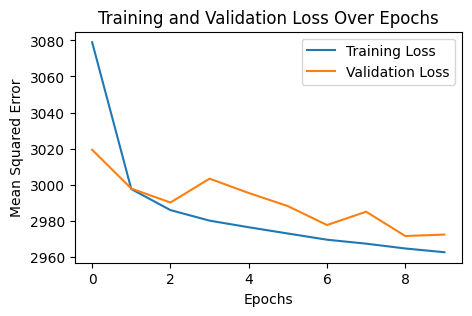

In [ ]:
#Plotting the training and validation loss v/s the number of epochs
plt.figure(figsize=(5,3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

##Linear Regression

In [ ]:
start_time = time.time()

#Input features
X = df2[['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN']]

#Target variable
y = df2['TAVG']

#Splitting the data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#Linear Regression initialization
linear_reg_model = LinearRegression()

#Linear Regression Training
linear_reg_model.fit(X_train, y_train)

#Obtaining the prediction values
linear_reg_preds_val = linear_reg_model.predict(X_val)

#Obtaining r2 score for regression analysis
linear_reg_r2_val = r2_score(y_val, linear_reg_preds_val)

#Printing the results for normal Linear Regression
print(f"Linear Regression R^2 on Validation Set: {linear_reg_r2_val}")
print()

#Lasso Regression with Hyperparameter Tuning for enhanced performance
lasso_params = {'alpha': [0.1,1,2,5,10,15,20,25,30]}

#Initializing Lasso Model
lasso_model = Lasso()

#Performing grid search to get the best hyperparameters
lasso_grid = GridSearchCV(lasso_model, lasso_params, cv=5)

#Training and getting the best fit for Lasso Regression
lasso_grid.fit(X_train, y_train)
best_lasso_model = lasso_grid.best_estimator_
lasso_preds_val = best_lasso_model.predict(X_val)
lasso_r2_val = r2_score(y_val, lasso_preds_val)

#Getting the r2 score on the validation dataset for the Lasso Regression
print(f"Lasso Regression R^2 on Validation Set: {lasso_r2_val}")
print()


end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Linear Regression R^2 on Validation Set: 0.3242816997249366

Lasso Regression R^2 on Validation Set: 0.32528180871124635

Execution time: 106.4652783870697 seconds


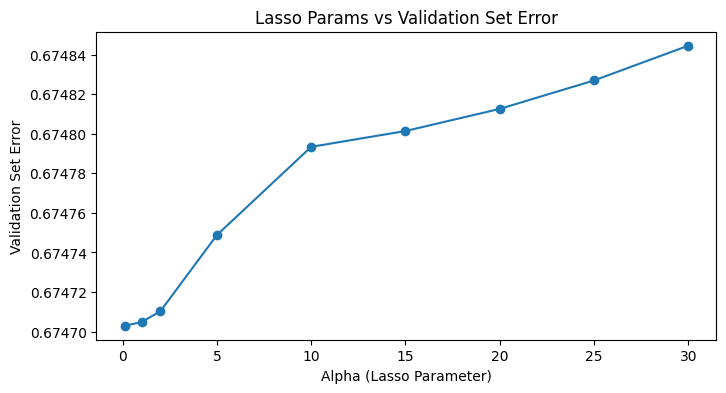

In [ ]:
#Plotting the above obtained Parameters (Lasso Params vs Validation Set Error)
lasso_errors = [1 - x for x in lasso_grid.cv_results_['mean_test_score']]
plt.figure(figsize=(8,4))
plt.plot(lasso_params['alpha'], lasso_errors, marker='o')
plt.title('Lasso Params vs Validation Set Error')
plt.xlabel('Alpha (Lasso Parameter)')
plt.ylabel('Validation Set Error')
plt.show()

##K Means Clustering

In [ ]:
#K Means Preprocessing
start_time = time.time()

#Declaring the headings of the columns in the csv file and storing them in df2
cols=["ID","date","ELEMENT","READING","M","Q","S","time"]
df2=pd.read_csv("2022.csv",header=None,names=cols,nrows=25000000)

#Taking only the features we need
selected_features = ['TMIN', 'TMAX', 'SNOW','PRCP','SNWD']
df2 = df2[df2['ELEMENT'].isin(selected_features)]

#Discarding all entries which failed the Quality Check
df2 = df2[df2['Q'].isna()]

#Dropping the columns which we do not need
dropthese=['Q','S','M','time']
df2=df2.drop(columns=dropthese)

df2=df2.reset_index()

#Pivoting the table (Similar to One Hot Encoding)
selected_features = ['TMIN', 'TMAX', 'SNOW','PRCP','SNWD']
df2=df2.pivot_table(index=['ID', 'date'], columns='ELEMENT', values='READING').reset_index()

#Dropping the rows which have any value blank, as empty values reduce performance of K Means Clustering
df2=df2.dropna(subset=selected_features, how='any')

#Conversion of date from integer to date format
df2['date'] = pd.to_datetime(df2['date'], format='%Y%m%d', errors='coerce')

groupeddf=df2.reset_index()
groupeddf=groupeddf.drop('index',axis=1)

#Declaring the columns of the other csv file named "Stations" to get location co-ordinates
cols=["ID","LATITUDE","LONGITUDE","ELEVATION","STATE","NAME","GSN","HCN","WMO"]
df=pd.read_csv("Station.csv",header=None, names=cols)

#Calculating the total run time of the entire program
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 64.05280113220215 seconds


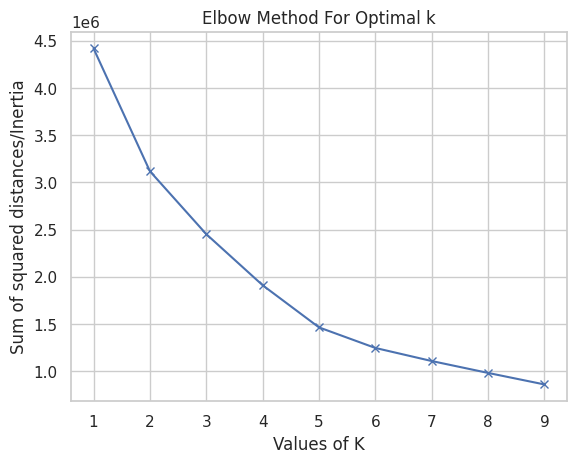


Execution time: 129.8731656074524 seconds


In [ ]:
#K Means Preprocessing
start_time = time.time()

#Normalizing the data for K Means
scaler=StandardScaler()

#Performing the WCSS (Elbow Method) to find the best value of K
#Declaring all required data structures, methods for evaluation and storage
sumsquared=[]
feature_scaled=scaler.fit_transform(groupeddf.drop(['ID','date'],axis=1))
groupeddf['cluster']=np.nan
k=range(1,10)
for num_clusters in k:
  kmeans=KMeans(n_clusters=num_clusters, random_state=42)
  kmeans.fit(feature_scaled)
  sumsquared.append(kmeans.inertia_)


#Visualizing the WCSS to see which K value we should take
plt.plot(k,sumsquared,'bx-')
plt.xlabel('Values of K')
plt.ylabel('Sum of squared distances/Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()
print()

#K=4 came out to be the best value of 'K', hence we perform KMeans
k=4
kmeans=KMeans(n_clusters=k, random_state=42)
groupeddf['cluster']=kmeans.fit_predict(feature_scaled)

#Merging both the files in order to get the latitude and longitude co-ordinates along with station info
merged_df = pd.merge(groupeddf,df, on='ID', how='inner')

#Calculating the total run time of the entire program
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

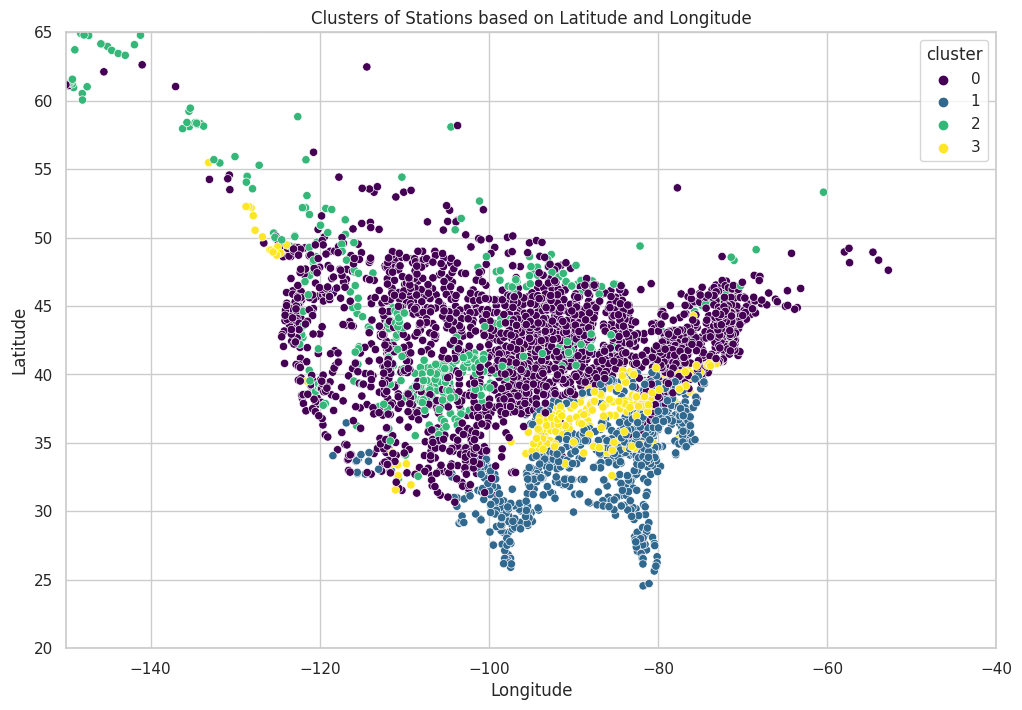

In [ ]:
#Visualization of the station along with their cluster color (Stations with the same cluster have similar climates)
#Setting seaborn style
sns.set(style="whitegrid")

#Creating a scatter plot with clusters colored differently
plt.figure(figsize=(12, 8))
sns.scatterplot(x='LONGITUDE', y='LATITUDE', hue='cluster', palette='viridis', data=merged_df[merged_df['date'] == '2022-01-01'])
#NOTE: This graph is for the date: 1st January 2022
#We cropped the graph so that it focuses on the United States latitude & longitude
#as there were very less stations outside the US
plt.xlim((-150,-40))
plt.xlim((-150,-40))
plt.ylim((20,65))
plt.title('Clusters of Stations based on Latitude and Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()